# Multi armed bandit

*Multi-armed bandit* is a problem of choosing between alternative options with unknown rewards, trying to maximize your expected reward and to learn it at the same time. You can find here a [wiki article](https://en.wikipedia.org/wiki/Multi-armed_bandit) and a [good blogpost](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html) about it. 

In this notebook, we'll create a simple environment for simulating such problems and try out a couple of strategies for dealing with them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import operator

%matplotlib inline

This class will generate rewards for each action taken by the solver. 

In [2]:
class BinaryEnvironment:
    
    def __init__(self, actions, rewards=None):
        '''
        actions: the set of actions that the bandit can take
        rewards: a dictionary of rewards per actions
        '''
        self.actions = actions
        if rewards is None:
            rewards = np.linspace(0.05, 0.95, len(self.actions))
        self.success_proba = dict(zip(self.actions, rewards))
        
    def generate_reward(self, action):
        '''
        Given an action we generate a reward a percentage of the time based on the value saved in success_proba
        action: action taken by the bandit
        '''
        return int(np.random.uniform() < self.success_proba[action])

This is the base class for different problem solvers.

In [3]:
class BaseBandit:
    
    def __init__(self, actions):
        self.actions = actions
        
    def reset(self):
        pass 
    
    def choose_next_action(self):
        raise NotImplementedError()
        
    def update(self, action, reward):
        raise NotImplementedError()

Now we can write a fuction that puts our solver into the environment and looks how well it works. 

In [4]:
def simulate(env, solver, n_sims=100, n_steps=100):
    '''
    Stimulate how well a solver scores
    env: what environment we use for our solver
    solver: the bandit that we are testing
    n_sims: how many times to run simulation
    n_steps: how many steps per simulation
    '''
    mean_rewards = []
    mean_curve = np.zeros(shape=n_steps)
    for sim in range(n_sims):
        solver.reset()
        actions = []
        rewards = []
        for i in range(n_steps):
            a = solver.choose_next_action()
            r = env.generate_reward(a)
            actions.append(a)
            rewards.append(r)
            solver.update(a, r)
        mean_rewards.append(np.mean(rewards))
        mean_curve += np.cumsum(rewards) / n_sims
        
    plt.plot(mean_curve / np.arange(1, n_steps+1))
    plt.xlabel('time')
    plt.ylabel('mean cumulative reward')
    return np.mean(mean_rewards)

Let's try a simple solver that just chooses an action at random

In [5]:
class RandomBandit(BaseBandit):
    '''
    A bandit that always takes a random action
    '''
    def choose_next_action(self):
        '''
        Chooses action randomly
        '''
        return np.random.choice(self.actions)
    
    def update(self, action, reward):
        pass

In [6]:
options = np.arange(10)
env = BinaryEnvironment(options)

For a random bandit, mean reward as a function of time is just a random walk: it doesn't use previous experience at all. 

0.5005

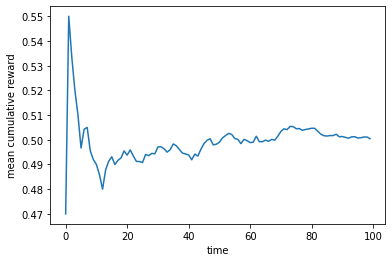

In [7]:
bandit = RandomBandit(actions=options)
simulate(env, bandit)

We can see that the mean value goes to 0.5, which makes a lot of sense being that the choice is random, the reward is 1 and the average chance of getting the reward over all actions is 50%.

## epsilon-greedy

Instead of pure randomness, we can code a so-called `epsilon-greedy` solver: with probability $\varepsilon$ it explores (takes a random uniform action), and with probability $1-\varepsilon$ it exploits: chooses the action with the best mean reward, according to its history. 

In [8]:
def dict_argmax(dictionary):
    return max(dictionary.items(), key=operator.itemgetter(1))[0]


class EpsilonGreedyBandit(BaseBandit):
    '''
    For epsilon greedy bandit with probability epsilon it takes a random uniform action, and with probability 1−epsilon it exploits
    '''
    def __init__(self, actions, epsilon=0.1):
        '''
        actions: the set of actions that the bandit can take
        epsilon: the hyperparameter epsilon for this solver
        '''
        super(EpsilonGreedyBandit, self).__init__(actions)
        self.epsilon = epsilon
        
    def reset(self):
        '''
        reset bandit variables
        '''
        self.action_counts = Counter()
        self.action_sums = Counter()
        self.update_means()
        
    def update_means(self):
        '''
        update mean reward recieved from every action
        '''
        self.means = {a: total / self.action_counts[a] for a, total in self.action_sums.items()}
        
    def choose_next_action(self):
        '''
        choose next action (explore or exploit) to do 
        '''
        if not self.means or np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            # dictionary argmax
            return dict_argmax(self.means)
        
    def update(self, action, reward):
        '''
        update variables based upon taken action and recieved reward
        action: action taken by bandit
        reward: reward recieved from given action
        '''
        self.action_counts[action] +=1
        self.action_sums[action] += reward
        self.update_means()

Now we can look at how different values of $\varepsilon$ perform.

You can see that when $\varepsilon$ is too high, the mean reward converges to a smaller value, because the proportion of random actions is high. 

And if $\varepsilon$ is too low, the solver sticks to a suboptimal action too early, and improves very slowly. 

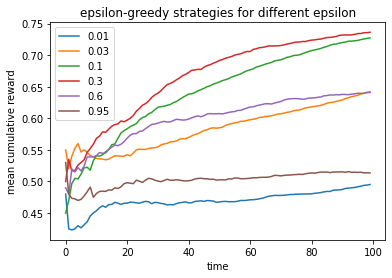

In [9]:
epsilons = [0.01, 0.03, 0.1, 0.3, 0.6, 0.95]
for eps in epsilons:
    bandit = EpsilonGreedyBandit(actions=options, epsilon=eps)
    simulate(env, bandit)
plt.legend(epsilons)
plt.title('epsilon-greedy strategies for different epsilon');

## UCB bandit

We can improve our solver even further, by making it choose on each step the action with the highest possible upper confidence bound for mean reward.

One of simple ways to approximate upper confidence bound for mean is to add several standard deviations of tne sample mean to the sample mean - like in normal distribution (to which distribution of sample mean will sooner or later converge):

$$ UCB = \bar{x} + m\frac{\hat{\sigma}}{\sqrt{n}}$$

Here $m$ is just some multiplier that reflects the degree of exploration we are going to do. The higher is this multiplier, the more will be the tendency to try actions with small $n$ and high $\hat{\sigma}$  - that is, the most uncertain actions.


In [10]:
class UpperConfidenceBandit(BaseBandit):
    '''
    For every action we try to choose the action with the highest possible upper confidence bound for mean reward. 
    Here m is just some multiplier that reflects the degree of exploration. The higher is this multiplier,  
    the more will be the tendency to try uncertain actions
    '''
    
    def __init__(self, actions, multiplier):
        '''
        actions: the set of actions that the bandit can take
        multiplier: the multiplier parameter for this model. Higher m = bandit more likely to explore
        '''
        super(UpperConfidenceBandit, self).__init__(actions)
        self.multiplier = multiplier
        
    def reset(self):
        '''
        reset bandit variables
        '''
        # we initialize the counters with one imaginary success and one imaginary failure
        # it's just a heuristic, nothing scientific about it
        self.action_counts = {action: 2 for action in self.actions}
        self.action_sums = {action: 1 for action in self.actions}
        self.update_ucbs()
        
    def update_ucbs(self):
        '''
        Update the upper confidence interval for the mean reward for each action 
        '''
        self.means = {a: self.action_sums[a] / self.action_counts[a] for a in self.actions}
        self.ucbs = {
            action: mean + self.multiplier*np.sqrt(mean - mean**2) / (np.sqrt(self.action_counts[action]))
            for action, mean in self.means.items()
        }
        
    def choose_next_action(self):
        '''
        choose the next action
        '''
        return dict_argmax(self.ucbs)
#         return max(self.means.items(), key=operator.itemgetter(1))[0]
    
    def update(self, action, reward):
        '''
        update variables based upon taken action and recieved reward
        action: action taken by bandit
        reward: reward recieved from given action
        '''
        self.action_counts[action] += 1
        self.action_sums[action] += reward
        self.update_ucbs()

Now we can try how our strategy works with different multipliers. 

It seems that a very small multiplier is already enough to explore all the options well enough and quickly converge to the best one. 

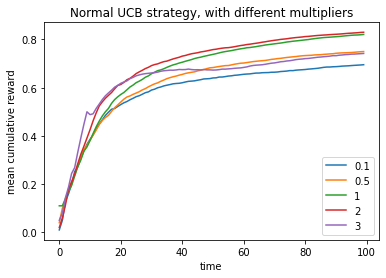

In [11]:
multipliers = [0.1, 0.5, 1, 2, 3]
mean_returns = []
for mul in multipliers:
    ucbb = UpperConfidenceBandit(actions=options, multiplier=mul)
    mean_returns.append(simulate(env, ucbb))
plt.legend(multipliers);
plt.title('Normal UCB strategy, with different multipliers');

assert max(mean_returns) > 0.8

In [12]:
mean_returns

[0.6953,
 0.7498999999999998,
 0.8208000000000003,
 0.8300000000000002,
 0.7420000000000002]

### Upper Confidence Decreasing Bandit

The environment we use is built in such a way, that the maximum possible average reward is 0.95 (if the solver knew the best action from the very beginning). 

Of course, no real algorithm can achieve this mean reward, but some algorithms can come close to it. 

Here we will experiment with changing the parameters of the bandit over time, e.g. gradually decreasing $\varepsilon$ or $m$, so that the algorithm starts with aggressive exploration and then quickly switches to exploitation. 


In [13]:
class UpperConfidenceDecreasingBandit(BaseBandit):
    '''
    For every action we try to choose the action with the highest possible upper confidence bound for mean reward. 
    Here m is just some multiplier that reflects the degree of exploration. The higher is this multiplier,  
    the more will be the tendency to try uncertain actions.
    We also have hyperparameter delta which will lower the multiplier over time, making the model more likely to exploit as time goes on.
    '''
    def __init__(self, actions, multiplier, delta):
        '''
        actions: the set of actions that the bandit can take
        multiplier: the multiplier parameter for this model. Higher m = bandit more likely to explore
        delta: the degree to which we lower out multiplier after every taken action 
        '''
        super(UpperConfidenceDecreasingBandit, self).__init__(actions)
        self.multiplier = multiplier
        self.delta = delta
        
    def reset(self):
        '''
        reset bandit variables
        '''
        # we initialize the counters with one imaginary success and one imaginary failure
        # it's just a heuristic, nothing scientific about it
        self.action_counts = {action: 2 for action in self.actions}
        self.action_sums = {action: 1 for action in self.actions}
        self.update_ucbs()
        
    def update_ucbs(self):
        '''
        Update the upper confidence interval for the mean reward for each action 
        '''
        self.means = {a: self.action_sums[a] / self.action_counts[a] for a in self.actions}
        self.ucbs = {
            action: mean + self.multiplier* np.sqrt(mean - mean**2) / (np.sqrt(self.action_counts[action]))
            for action, mean in self.means.items()
        }
        self.multiplier -= self.delta
        
    def choose_next_action(self):
        '''
        choose the next action
        '''
        return dict_argmax(self.ucbs)
    
    def update(self, action, reward):
        '''
        update variables based upon taken action and recieved reward
        action: action taken by bandit
        reward: reward recieved from given action
        '''
        self.action_counts[action] += 1
        self.action_sums[action] += reward
        self.update_ucbs()

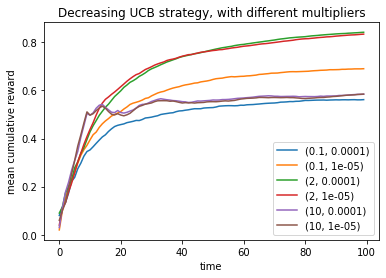

In [14]:
multipliers = [0.1, 2, 10]
# multipliers = [2]
delta = [0.0001, 0.00001]
mean_returns = []
legend = []

for mul in multipliers:
    for delt in delta:
        ucbb = UpperConfidenceDecreasingBandit(actions=options, multiplier=mul, delta=delt)
        mean_returns.append(simulate(env, ucbb))
        

plt.legend([(mul, delt) for mul in multipliers for delt in delta]);
plt.title('Decreasing UCB strategy, with different multipliers');

assert max(mean_returns) > 0.8

In [15]:
mean_returns

[0.5618,
 0.6903999999999999,
 0.8420999999999998,
 0.8342000000000002,
 0.5844,
 0.5848]